In [1]:
import torch
from circuits import Circuit,Kinds
from learn import Trainer
from data import Data

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(precision=3, linewidth=200)

Using cpu device


[(IVS, 1, 0), (R, 1, 0), (R, 1, 0)]


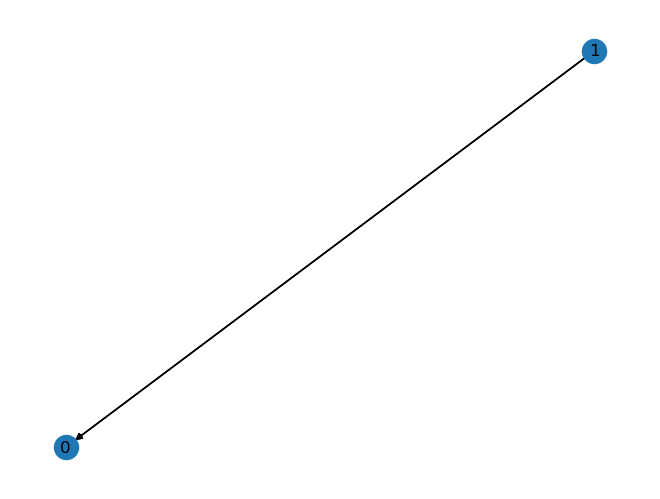

In [3]:
c = Circuit()
c.ladder(Kinds.IVS,Kinds.R,2)
c.elements[0].attr = 1
c.elements[1].attr = 1
c.elements[2].attr = 1
print(c.elements)
c.draw()

In [4]:
data = Data(c)
trainer = Trainer(data, 1e-1)

c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:111: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [5]:
stable_threshold = 1e-5
loss_threshold = 1e-20
i_sol,v_sol,a_sol,loss,epoch = trainer.run(1000, stable_threshold, loss_threshold)
c.load(i_sol,v_sol,a_sol)
i_sol,v_sol,a_sol,epoch

threshold met
reset_count = 0


(tensor([-2.,  1.,  1.]),
 tensor([1., 1., 1.]),
 tensor([1., 1., 1.], grad_fn=<IndexPutBackward0>),
 0)

In [6]:
c.elements[0].i, c.elements[0].v, c.elements[0].attr

(-2.0, 1.0, 1.0)

In [7]:
c.elements[1].i, c.elements[1].v, c.elements[1].attr

(1.0, 1.0, 1.0)

In [8]:
c.elements[2].i, c.elements[2].v, c.elements[2].attr

(1.0, 1.0, 1.0)